In [1]:
import glob
import os
import re
import numpy as np
import pandas as pd
import rasterio
import geopandas as gpd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from scipy.ndimage import binary_dilation, label
from rasterio.features import geometry_mask
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score, classification_report, confusion_matrix
import seaborn as sns
import joblib

# Define the directories containing images and shapefiles
image_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_images"
shapefile_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_train"
unlabeled_image_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_unlabeled"
new_walrus_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\walrus_shapefiles"

# Use glob to list all .tif and .shp files in the specified directories
image_paths = glob.glob(f"{image_dir}/*.tif")
shapefile_paths = glob.glob(f"{shapefile_dir}/*.shp")
unlabeled_image_paths = glob.glob(f"{unlabeled_image_dir}/*.tif")
new_walrus_paths = glob.glob(f"{new_walrus_dir}/*.shp")

# Function to extract island name and date from file names
def extract_island_and_date(filename):
    pattern = r'([a-zA-Z]+)_(\d{8})'
    match = re.search(pattern, filename)
    if match:
        return match.group(1), match.group(2)
    return None, None

def pair_files(image_paths, shapefile_paths):
    pairs = {}
    for image_path in image_paths:
        island, date = extract_island_and_date(os.path.basename(image_path))
        if island is None or date is None:
            print(f"Failed to extract island and date from {image_path}")
            continue

        matching_shapefiles = [shapefile for shapefile in shapefile_paths if island in shapefile and date in shapefile]
        if matching_shapefiles:
            pairs[image_path] = matching_shapefiles[0]

    return pairs

training_pairs = pair_files(image_paths, shapefile_paths)
validation_pairs = pair_files(unlabeled_image_paths, new_walrus_paths)

def extract_features_labels(image_path, shapefile):
    with rasterio.open(image_path) as src:
        image = src.read()
        transform = src.transform

    features = []
    labels = []

    gdf = gpd.read_file(shapefile)
    for _, row in gdf.iterrows():
        mask = geometry_mask([row['geometry']], transform=transform, invert=True, out_shape=(src.height, src.width))
        feature_pixels = image[:, mask]
        for pixel in feature_pixels.T:
            features.append(pixel)
            labels.append(row['label'])

    return np.array(features), np.array(labels)

def get_dataset(file_pairs):
    features = []
    labels = []

    for image_path, shapefile in file_pairs.items():
        img_features, img_labels = extract_features_labels(image_path, shapefile)
        features.append(img_features)
        labels.append(img_labels)

    features = np.vstack(features)
    labels = np.hstack(labels)

    return features, labels

# Get the dataset
features, labels = get_dataset(training_pairs)

# Encode labels
le = LabelEncoder()
encoded_labels = le.fit_transform(labels)

# Combine classes
combined_labels = np.where(np.isin(labels, ['rock', 'ice', 'freshwater']), 'land',
                           np.where(np.isin(labels, ['walrus_pure', 'walrus_mixed']), 'walrus', labels))
combined_le = LabelEncoder()
combined_encoded_labels = combined_le.fit_transform(combined_labels)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(features, combined_encoded_labels, test_size=0.2, stratify=combined_encoded_labels, random_state=42)


In [2]:
# Load the saved models
binary_model = joblib.load('binary_ocean_not_ocean_model11.joblib')
walrus_model = joblib.load('walrus_vs_land_model11.joblib')


In [3]:
# Define the post-process function to ensure one continuous ocean region
def post_process_prediction(prediction, original_shape=None, passes=3):
    print("Inside post_process_prediction function.")
    
    is_1d = prediction.ndim == 1
    print(f"Initial prediction shape: {prediction.shape}")
    print(f"Initial is_1d: {is_1d}")

    if original_shape is not None and is_1d:
        prediction = prediction.reshape(original_shape)
        is_1d = False
        print(f"Reshaped prediction to: {prediction.shape}")

    ocean_value = combined_le.transform(['ocean'])[0]
    walrus_value = combined_le.transform(['walrus'])[0]
    land_value = combined_le.transform(['land'])[0]

    for pass_num in range(passes):
        print(f"Pass {pass_num + 1}/{passes}")
        ocean_mask = prediction == ocean_value
        land_mask = prediction == land_value

        print(f"Ocean mask sum: {ocean_mask.sum()}")
        print(f"Land mask sum: {land_mask.sum()}")

        ocean_mask_2d = ocean_mask
        structure = np.ones((30, 30), dtype=bool)  # 2D structure for 2D input

        print(f"Ocean mask 2D shape: {ocean_mask_2d.shape}")
        print(f"Structure shape: {structure.shape}")

        try:
            ocean_buffer = binary_dilation(ocean_mask_2d, structure=structure)
        except RuntimeError as e:
            print(f"Error during binary_dilation: {e}")
            return prediction

        print(f"Ocean buffer created. Shape: {ocean_buffer.shape}")

        walrus_mask = prediction == walrus_value
        walrus_mask[~ocean_buffer] = False
        prediction[walrus_mask] = walrus_value

        print(f"Walrus mask updated. Walrus count: {(prediction == walrus_value).sum()}")

        # Remove speckles
        prediction = remove_speckles(prediction, min_size=100, target_classes=[ocean_value, land_value])
        print(f"Speckles removed. Unique values: {np.unique(prediction)}")

        # Ensure only one large ocean region
        ocean_mask = prediction == ocean_value  # Recalculate the ocean mask after removing speckles
        labeled_ocean, num_ocean_features = label(ocean_mask)
        ocean_sizes = np.bincount(labeled_ocean.ravel())
        largest_ocean_label = ocean_sizes[1:].argmax() + 1  # largest connected component (ignoring background)

        for ocean_label in range(1, num_ocean_features + 1):
            if ocean_label != largest_ocean_label:
                prediction[labeled_ocean == ocean_label] = land_value

        print(f"Removed smaller ocean regions. Ocean mask sum after removal: {(prediction == ocean_value).sum()}")

    if is_1d:
        prediction = prediction.ravel()

    print(f"Final prediction shape: {prediction.shape}")
    return prediction

# Function to perform prediction and post-processing
def predict_and_post_process(image_path, binary_model, walrus_model):
    with rasterio.open(image_path) as src:
        image = src.read()
        height, width = image.shape[1], image.shape[2]

        image_reshaped = image.reshape(8, -1).T

        # Initial predictions
        ocean_predictions = binary_model.predict(image_reshaped)
        land_mask = ocean_predictions == 0
        walrus_probabilities = walrus_model.predict_proba(image_reshaped[land_mask])[:, 1]

        walrus_threshold = 0.1
        walrus_predictions = (walrus_probabilities > walrus_threshold).astype(int)

        combined_predictions = np.zeros_like(ocean_predictions)
        combined_predictions[~land_mask] = combined_le.transform(['ocean'])[0]
        combined_predictions[land_mask] = np.where(walrus_predictions == 1,
                                                   combined_le.transform(['walrus'])[0],
                                                   combined_le.transform(['land'])[0])

        print("Before post-processing:")
        print(f"Ocean pixel count: {np.sum(combined_predictions == combined_le.transform(['ocean'])[0])}")
        print(f"Land pixel count: {np.sum(combined_predictions == combined_le.transform(['land'])[0])}")
        print(f"Walrus pixel count: {np.sum(combined_predictions == combined_le.transform(['walrus'])[0])}")

        # Post-process the predictions
        combined_predictions = post_process_prediction(combined_predictions, (height, width))

        print("After post-processing:")
        print(f"Ocean pixel count: {np.sum(combined_predictions == combined_le.transform(['ocean'])[0])}")
        print(f"Land pixel count: {np.sum(combined_predictions == combined_le.transform(['land'])[0])}")
        print(f"Walrus pixel count: {np.sum(combined_predictions == combined_le.transform(['walrus'])[0])}")

        return combined_predictions, (height, width)

Inside post_process_prediction function.
Initial prediction shape: (242707,)
Initial is_1d: True
Reshaped prediction to: (242707,)
Pass 1/3
Ocean mask sum: 155718
Land mask sum: 86989
Ocean mask 2D shape: (242707,)
Structure shape: (30, 30)
Error during binary_dilation: structure and input must have same dimensionality
The shape of y_pred: (242707,)
The shape of X_test: (242707, 8)


C:\Users\Student\Documents\walrus_code\.venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model Evaluation Metrics (Post-processed):
Accuracy: 0.9967862484394764
Precision: 0.9960431907516901
Recall: 0.9967862484394764
F1 Score: 0.9964133768973241
Cohen's Kappa: 0.9930137662210685

Classification Report (Post-processed):


C:\Users\Student\Documents\walrus_code\.venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Student\Documents\walrus_code\.venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Student\Documents\walrus_code\.venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

              precision    recall  f1-score   support

        land       0.99      1.00      1.00     86668
       ocean       1.00      1.00      1.00    155857
      walrus       0.00      0.00      0.00       182

    accuracy                           1.00    242707
   macro avg       0.66      0.67      0.66    242707
weighted avg       1.00      1.00      1.00    242707


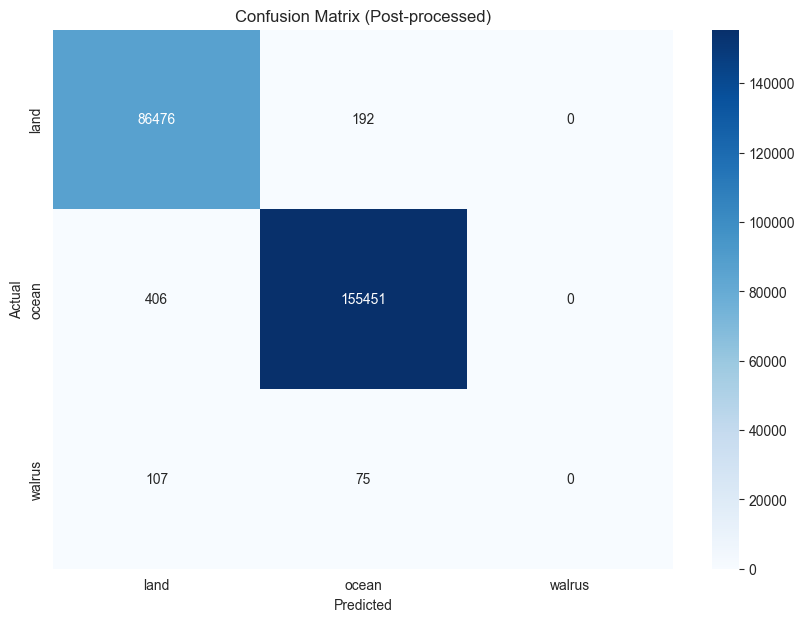

In [4]:
# Evaluation metrics with post-processing
y_pred = binary_model.predict(X_test)
land_mask = y_pred == 0
y_pred[land_mask] = walrus_model.predict(X_test[land_mask])

# Post-process the predictions
y_pred_post = post_process_prediction(y_pred, original_shape=(len(y_pred),))

# Print the shapes of y_pred and X_test
print(f"The shape of y_pred: {y_pred_post.shape}")
print(f"The shape of X_test: {X_test.shape}")

# Calculate Evaluation Metrics
accuracy = accuracy_score(y_test, y_pred_post)
precision = precision_score(y_test, y_pred_post, average='weighted')
recall = recall_score(y_test, y_pred_post, average='weighted')
f1 = f1_score(y_test, y_pred_post, average='weighted')
kappa = cohen_kappa_score(y_test, y_pred_post)

# Print Metrics
print("Model Evaluation Metrics (Post-processed):")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Cohen's Kappa: {kappa}")

print("\nClassification Report (Post-processed):")
print(classification_report(y_test, y_pred_post, target_names=combined_le.classes_))

# Compute and plot confusion matrix
cm = confusion_matrix(y_test, y_pred_post)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=combined_le.classes_,
            yticklabels=combined_le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Post-processed)')
plt.show()

In [5]:
# Define a color map for the labels
label_colors = {
    'ocean': 'cornflowerblue',
    'land': 'antiquewhite',
    'walrus': 'mediumorchid'
}

# Create a fixed color map based on combined labels
cmap = mcolors.ListedColormap([label_colors[label] for label in combined_le.classes_])

# Function to plot predicted images
def plot_predicted_image(image_path, binary_model, walrus_model):
    post_processed_predictions, original_shape = predict_and_post_process(image_path, binary_model, walrus_model)
    plt.figure(figsize=(10, 10))
    plt.title(f"Predicted classes for {os.path.basename(image_path)}")
    plt.imshow(post_processed_predictions, cmap=cmap, vmin=0, vmax=len(combined_le.classes_)-1)

    # Create a color bar with fixed labels
    cbar = plt.colorbar(ticks=range(len(combined_le.classes_)), label='Class')
    cbar.ax.set_yticklabels(combined_le.classes_)

    plt.show()

# Predict and plot images using the new centralized function
for image_path in image_paths + unlabeled_image_paths:
    plot_predicted_image(image_path, binary_model, walrus_model)

Before post-processing:
Ocean pixel count: 117818
Land pixel count: 137135
Walrus pixel count: 4037
Inside post_process_prediction function.
Initial prediction shape: (258990,)
Initial is_1d: True
Reshaped prediction to: (445, 582)
Pass 1/3
Ocean mask sum: 117818
Land mask sum: 137135
Ocean mask 2D shape: (445, 582)
Structure shape: (30, 30)
Ocean buffer created. Shape: (445, 582)
Walrus mask updated. Walrus count: 4037


NameError: name 'remove_speckles' is not defined